# Segmentacja nczyń krwionośnych dna oka z wykorzystaniem U net
## Autorzy:
- Jędrzej Warczyński 148234
- Uladzislau Abeziuk 150243

## Wykorzytyswane biblioteki

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm import tqdm
import cv2
import os

import tensorflow as tf

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Zdefinowanie ścieżki do zdjęć
źródło danych:
https://www5.cs.fau.de/research/data/fundus-images/

In [31]:
DATA_FOLDER = "drive/MyDrive/data"
IMAGES_FOLDER = os.path.join(DATA_FOLDER, "images")
MANUAL_FOLDER = os.path.join(DATA_FOLDER, "manual")
FOV_MASK_FOLDER = os.path.join(DATA_FOLDER, "mask")
SEGMENTED_IMAGES_FOLDER = "drive/MyDrive/segmented_images"

MODEL_FOLDER = "drive/MyDrive"

In [4]:
filenames = os.listdir(IMAGES_FOLDER)
filenames.sort()
IMAGES_NUM = len(filenames)
IMAGES_NUM

45

In [5]:
TRAIN_IMAGES_NUM = 40

In [6]:
img_path = os.path.join(IMAGES_FOLDER, filenames[0])
filenames[0]
img_path
img = cv2.imread(img_path) 
img.shape

(2336, 3504, 3)

## Zdefinowanie zbioru treningowego z pierwszych 40 z 45 zdjęć

In [7]:
X_train = np.zeros((TRAIN_IMAGES_NUM, *img.shape), dtype=np.uint8)
X_train.shape

(40, 2336, 3504, 3)

## Pobranie maski espereckiej dla zbioru treningowego

In [8]:
Y_train = np.zeros((TRAIN_IMAGES_NUM, *img.shape[:2], 1), dtype=bool)
Y_train.shape

(40, 2336, 3504, 1)

## Przygotowanie zbioru treningowego
konwersja zdjęć do tablicy numpy o wymaganym wymiarze

In [9]:
for i, filename in tqdm(enumerate(filenames[:TRAIN_IMAGES_NUM]), total=TRAIN_IMAGES_NUM):
  img_path = os.path.join(IMAGES_FOLDER, filename)
  manual_path = os.path.join(MANUAL_FOLDER, filename.split('.')[0] + '.tif')

  X_train[i] = cv2.imread(img_path) 

  mask = np.zeros((*img.shape[:2], 1))
  manual = cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE)
  manual_extended = np.expand_dims(manual, -1)
  mask = np.maximum(mask, manual_extended)
  Y_train[i] = mask

100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


In [10]:
X_train.shape

(40, 2336, 3504, 3)

In [11]:
Y_train.shape

(40, 2336, 3504, 1)

## Zdefinowanie modelu sieci U-net z wykorzytsaniem biblioteki keras

In [12]:
inputs = tf.keras.layers.Input(img.shape)
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2336, 3504,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda (Lambda)                (None, 2336, 3504,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 2336, 3504,   448         ['lambda[0][0]']                 
                                16)                                                           

In [13]:
model_path = os.path.join(MODEL_FOLDER, "U_net_model_vessels")

### Wczesne zatrzymywanie w celu zapobiegania przeuczeniu oraz zapisywanie modelu dla przy poprawie wyniku

In [14]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        checkpointer]

## Trenowanie modelu

In [15]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=1, epochs=25, callbacks=callbacks, verbose=2)

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.31351, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 88s - loss: 0.3628 - accuracy: 0.9098 - val_loss: 0.3135 - val_accuracy: 0.9189 - 88s/epoch - 3s/step
Epoch 2/25

Epoch 2: val_loss improved from 0.31351 to 0.27101, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 54s - loss: 0.2567 - accuracy: 0.9236 - val_loss: 0.2710 - val_accuracy: 0.9189 - 54s/epoch - 2s/step
Epoch 3/25

Epoch 3: val_loss did not improve from 0.27101
32/32 - 48s - loss: 0.2465 - accuracy: 0.9236 - val_loss: 0.2819 - val_accuracy: 0.9189 - 48s/epoch - 2s/step
Epoch 4/25

Epoch 4: val_loss improved from 0.27101 to 0.24134, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.2324 - accuracy: 0.9236 - val_loss: 0.2413 - val_accuracy: 0.9189 - 53s/epoch - 2s/step
Epoch 5/25

Epoch 5: val_loss did not improve from 0.24134
32/32 - 48s - loss: 0.2341 - accuracy: 0.9236 - val_loss: 0.2503 - val_accuracy: 0.9189 - 48s/epoch - 2s/step
Epoch 6/25

Epoch 6: val_loss improved from 0.24134 to 0.23335, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 54s - loss: 0.2237 - accuracy: 0.9236 - val_loss: 0.2333 - val_accuracy: 0.9189 - 54s/epoch - 2s/step
Epoch 7/25

Epoch 7: val_loss improved from 0.23335 to 0.21610, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 54s - loss: 0.2146 - accuracy: 0.9242 - val_loss: 0.2161 - val_accuracy: 0.9248 - 54s/epoch - 2s/step
Epoch 8/25

Epoch 8: val_loss did not improve from 0.21610
32/32 - 49s - loss: 0.2203 - accuracy: 0.9155 - val_loss: 0.2426 - val_accuracy: 0.9191 - 49s/epoch - 2s/step
Epoch 9/25

Epoch 9: val_loss improved from 0.21610 to 0.20032, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.2051 - accuracy: 0.9239 - val_loss: 0.2003 - val_accuracy: 0.9190 - 53s/epoch - 2s/step
Epoch 10/25

Epoch 10: val_loss did not improve from 0.20032
32/32 - 48s - loss: 0.1722 - accuracy: 0.9257 - val_loss: 0.2069 - val_accuracy: 0.9218 - 48s/epoch - 2s/step
Epoch 11/25

Epoch 11: val_loss improved from 0.20032 to 0.15490, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.1669 - accuracy: 0.9327 - val_loss: 0.1549 - val_accuracy: 0.9470 - 53s/epoch - 2s/step
Epoch 12/25

Epoch 12: val_loss did not improve from 0.15490
32/32 - 48s - loss: 0.1521 - accuracy: 0.9469 - val_loss: 0.1728 - val_accuracy: 0.9415 - 48s/epoch - 2s/step
Epoch 13/25

Epoch 13: val_loss improved from 0.15490 to 0.13754, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.1289 - accuracy: 0.9577 - val_loss: 0.1375 - val_accuracy: 0.9546 - 53s/epoch - 2s/step
Epoch 14/25

Epoch 14: val_loss improved from 0.13754 to 0.13559, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.1207 - accuracy: 0.9590 - val_loss: 0.1356 - val_accuracy: 0.9511 - 53s/epoch - 2s/step
Epoch 15/25

Epoch 15: val_loss improved from 0.13559 to 0.12985, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 54s - loss: 0.1182 - accuracy: 0.9605 - val_loss: 0.1299 - val_accuracy: 0.9535 - 54s/epoch - 2s/step
Epoch 16/25

Epoch 16: val_loss did not improve from 0.12985
32/32 - 48s - loss: 0.1133 - accuracy: 0.9608 - val_loss: 0.1316 - val_accuracy: 0.9560 - 48s/epoch - 1s/step
Epoch 17/25

Epoch 17: val_loss did not improve from 0.12985
32/32 - 48s - loss: 0.1116 - accuracy: 0.9617 - val_loss: 0.1367 - val_accuracy: 0.9549 - 48s/epoch - 1s/step
Epoch 18/25

Epoch 18: val_loss improved from 0.12985 to 0.11609, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.1079 - accuracy: 0.9625 - val_loss: 0.1161 - val_accuracy: 0.9573 - 53s/epoch - 2s/step
Epoch 19/25

Epoch 19: val_loss improved from 0.11609 to 0.11115, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.1043 - accuracy: 0.9634 - val_loss: 0.1112 - val_accuracy: 0.9602 - 53s/epoch - 2s/step
Epoch 20/25

Epoch 20: val_loss did not improve from 0.11115
32/32 - 48s - loss: 0.1009 - accuracy: 0.9640 - val_loss: 0.1354 - val_accuracy: 0.9509 - 48s/epoch - 2s/step
Epoch 21/25

Epoch 21: val_loss improved from 0.11115 to 0.10644, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 53s - loss: 0.0982 - accuracy: 0.9650 - val_loss: 0.1064 - val_accuracy: 0.9612 - 53s/epoch - 2s/step
Epoch 22/25

Epoch 22: val_loss did not improve from 0.10644
32/32 - 48s - loss: 0.0962 - accuracy: 0.9653 - val_loss: 0.1101 - val_accuracy: 0.9574 - 48s/epoch - 2s/step
Epoch 23/25

Epoch 23: val_loss improved from 0.10644 to 0.10314, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 54s - loss: 0.0946 - accuracy: 0.9655 - val_loss: 0.1031 - val_accuracy: 0.9613 - 54s/epoch - 2s/step
Epoch 24/25

Epoch 24: val_loss improved from 0.10314 to 0.09911, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 54s - loss: 0.0945 - accuracy: 0.9657 - val_loss: 0.0991 - val_accuracy: 0.9638 - 54s/epoch - 2s/step
Epoch 25/25

Epoch 25: val_loss improved from 0.09911 to 0.09049, saving model to drive/MyDrive/U_net_model_vessels


32/32 - 56s - loss: 0.0937 - accuracy: 0.9655 - val_loss: 0.0905 - val_accuracy: 0.9670 - 56s/epoch - 2s/step


In [16]:
TEST_SIZE = len(filenames) - TRAIN_IMAGES_NUM
TEST_SIZE

5

In [17]:
X_test = np.zeros((TEST_SIZE, *img.shape), dtype=np.uint8)
X_test.shape

(5, 2336, 3504, 3)

In [18]:
Y_test = np.zeros((TEST_SIZE, *img.shape[:2], 1), dtype=np.uint8)
Y_test.shape

(5, 2336, 3504, 1)

## Przygotowanie danych testowych

In [19]:
for i, filename in tqdm(enumerate(filenames[TRAIN_IMAGES_NUM:]), total=TEST_SIZE):
  img_path = os.path.join(IMAGES_FOLDER, filename)
  manual_path = os.path.join(MANUAL_FOLDER, filename.split('.')[0] + '.tif')

  X_test[i] = cv2.imread(img_path) 
  Y_test[i] = np.expand_dims(cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE),-1)

100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


## Wyznaczenie predykcji

In [20]:
predictions = model.predict(X_test, batch_size=1)
predictions.shape

5/5 [==============================] - 1s 267ms/step


(5, 2336, 3504, 1)

## Wyzanczenie dokładnośći predykcji na zbiorze testowym

In [21]:
_, accuracy = model.evaluate(X_test, Y_test, batch_size=1)
accuracy

5/5 [==============================] - 2s 266ms/step - loss: -14.6978 - accuracy: 0.9151


0.9151469469070435

## Pobranie wytrenowanego modelu z pliku po wcześniejszym zapisaniu

In [22]:
loaded_model = tf.keras.models.load_model(model_path)
_, loaded_accuracy = loaded_model.evaluate(X_test, Y_test, batch_size=1)
loaded_accuracy

5/5 [==============================] - 2s 265ms/step - loss: -14.6978 - accuracy: 0.9151


0.9151469469070435

In [23]:
loaded_model_predictions = loaded_model.predict(X_test, batch_size=1)
loaded_model_predictions.shape

5/5 [==============================] - 1s 258ms/step


(5, 2336, 3504, 1)

## Transofrmacja predykcji do postaci akcpetowanej przez wizualizator predykcji
Zamiana prawdopodobieństw predykcji na konkretne wartośći pikseli  
zmiana wymiarowości

In [37]:
predictions_pixels = (loaded_model_predictions > 0.5).astype(np.uint8)
predictions_pixels.shape

(5, 2336, 3504, 1)

In [27]:
prediction_masks = []
expert_masks = []
for i in range(TEST_SIZE):
  reshaped_prediction = np.reshape(predictions_pixels[i], img.shape[:2])
  reshaped_prediction = reshaped_prediction * 255
  prediction_masks.append(reshaped_prediction)
  expert_masks.append(np.reshape(Y_test[i], img.shape[:2]))

## Klasa do wyzanaczania i wizualizacji metryk

In [ ]:
class MetricsVisualizer:
    def __init__(self):
        self.TP = []
        self.TN = []
        self.FP = []
        self.FN = []

        self.accuracy = []
        self.sensitivity = []
        self.specificity = []

        self.mean_TP = None
        self.mean_TN = None
        self.mean_FP = None
        self.mean_FN = None

        self.mean_accuracy = None
        self.mean_sensitivity = None
        self.mean_specificity = None

        self.predictions = []
        self.ground_truths = []
        self.file_names = []

    def calculate_metrics(self, ground_truth, predicted, file_name):
        self.TP.append(np.sum(np.logical_and(ground_truth == 255, predicted == 255)))
        self.TN.append(np.sum(np.logical_and(ground_truth == 0, predicted == 0)))
        self.FP.append(np.sum(np.logical_and(ground_truth == 0, predicted != 0)))
        self.FN.append(np.sum(np.logical_and(ground_truth == 255, predicted != 255)))

        self.accuracy.append((self.TP[-1] + self.TN[-1]) / (self.TP[-1] + self.TN[-1] + self.FP[-1] + self.FN[-1]))
        self.sensitivity.append(self.TP[-1] / (self.TP[-1] + self.FN[-1]))
        self.specificity.append(self.TN[-1] / (self.TN[-1] + self.FP[-1]))

        self.predictions.append(predicted)
        self.ground_truths.append(ground_truth)
        self.file_names.append(file_name)

    def calculate_mean_metrics(self):
        self.mean_TP = np.mean(self.TP)
        self.mean_TN = np.mean(self.TN)
        self.mean_FP = np.mean(self.FP)
        self.mean_FN = np.mean(self.FN)

        self.mean_accuracy = np.mean(self.accuracy)
        self.mean_sensitivity = np.mean(self.sensitivity)
        self.mean_specificity = np.mean(self.specificity)

    def visualize(self):
        self.tabulate_metrics()
        for i in range(len(self.file_names)):
            self.visualize_single(i)

    def visualize_single(self, i):
        fig, axs = plt.subplots(2, 3, figsize=(18, 12))

        axs[0, 0].imshow(self.predictions[i], cmap='gray')
        axs[0, 0].set_title(f"{self.file_names[i]} Prediction")

        axs[0, 1].imshow(self.ground_truths[i], cmap='gray')
        axs[0, 1].set_title(f"{self.file_names[i]} Ground Truth")

        axs[0, 2].imshow(self.calculate_misclassification_mask(i), cmap='gray')
        axs[0, 2].set_title(f"{self.file_names[i]} Misclassification Mask")

        cm = confusion_matrix(self.ground_truths[i].flatten(), self.predictions[i].flatten())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axs[1, 0])
        axs[1, 0].set_title(f"{self.file_names[i]} Confusion Matrix")

        axs[1, -1].remove()

        axs[1, 1].bar(["TP", "TN", "FP", "FN"], [self.TP[i], self.TN[i], self.FP[i], self.FN[i]])
        axs[1, 1].set_title(f"{self.file_names[i]} Confusion Matrix - Bar Plot")

        plt.tight_layout()
        plt.show()

    def tabulate_metrics(self):
      headers = ["Image", "Accuracy", "Sensitivity", "Specificity", "TP", "TN", "FP", "FN"]
      self.calculate_mean_metrics()
      # data = [self.accuracy, self.sensitivity, self.specificity, self.TP, self.TN, self.FP, self.FN]
      data = [[file_name, accuracy, sensitivity, specificity, TP, TN, FP, FN]
              for file_name, accuracy, sensitivity, specificity, TP, TN, FP, FN
              in zip(self.file_names, self.accuracy, self.sensitivity, self.specificity, self.TP, self.TN, self.FP, self.FN)]
      data.append(
          ["mean", self.mean_accuracy, self.mean_sensitivity, self.mean_specificity,
          self.mean_TP, self.mean_TN, self.mean_FP, self.mean_FN
          ]
      )
      print(tabulate(data, headers=headers))

    def calculate_misclassification_mask(self, i=0):
      misclassified_mask = np.zeros((*self.ground_truths[i].shape, 3), dtype=np.uint8)
      misclassified_mask[np.logical_and(self.predictions[i] > 128, self.ground_truths[i] <= 128)] = [255, 0, 0]
      misclassified_mask[np.logical_and(self.predictions[i] > 128, self.ground_truths[i] > 128)] = [255, 255, 255]
      misclassified_mask[np.logical_and(self.predictions[i] < 128, self.ground_truths[i] > 128)] = [0, 0, 255]
      return misclassified_mask


## Wzualizacja i wyzanczneie metryk predykcji
- kolorem niebieksim zaznaczone naczynia niewykryte przez model  
- kolrem czerownym tło błędnie sklasyfikowane przez model jako naczynie krwionośne

Image        Accuracy    Sensitivity    Specificity      TP           TN        FP      FN
---------  ----------  -------------  -------------  ------  -----------  --------  ------
14_dr.JPG    0.964482       0.67243        0.986679  388778  7.50584e+06  101338    189391
14_g.jpg     0.968777       0.744826       0.990181  531846  7.39793e+06   73364    182208
14_h.jpg     0.96553        0.670501       0.986164  358747  7.54445e+06  105849    176296
15_dr.JPG    0.965407       0.711127       0.985491  426099  7.47609e+06  110065    173089
15_g.jpg     0.96564        0.58392        0.998086  374436  7.52966e+06   14442    266809
mean         0.965967       0.676561       0.98932   415981  7.49079e+06   81011.6  197559


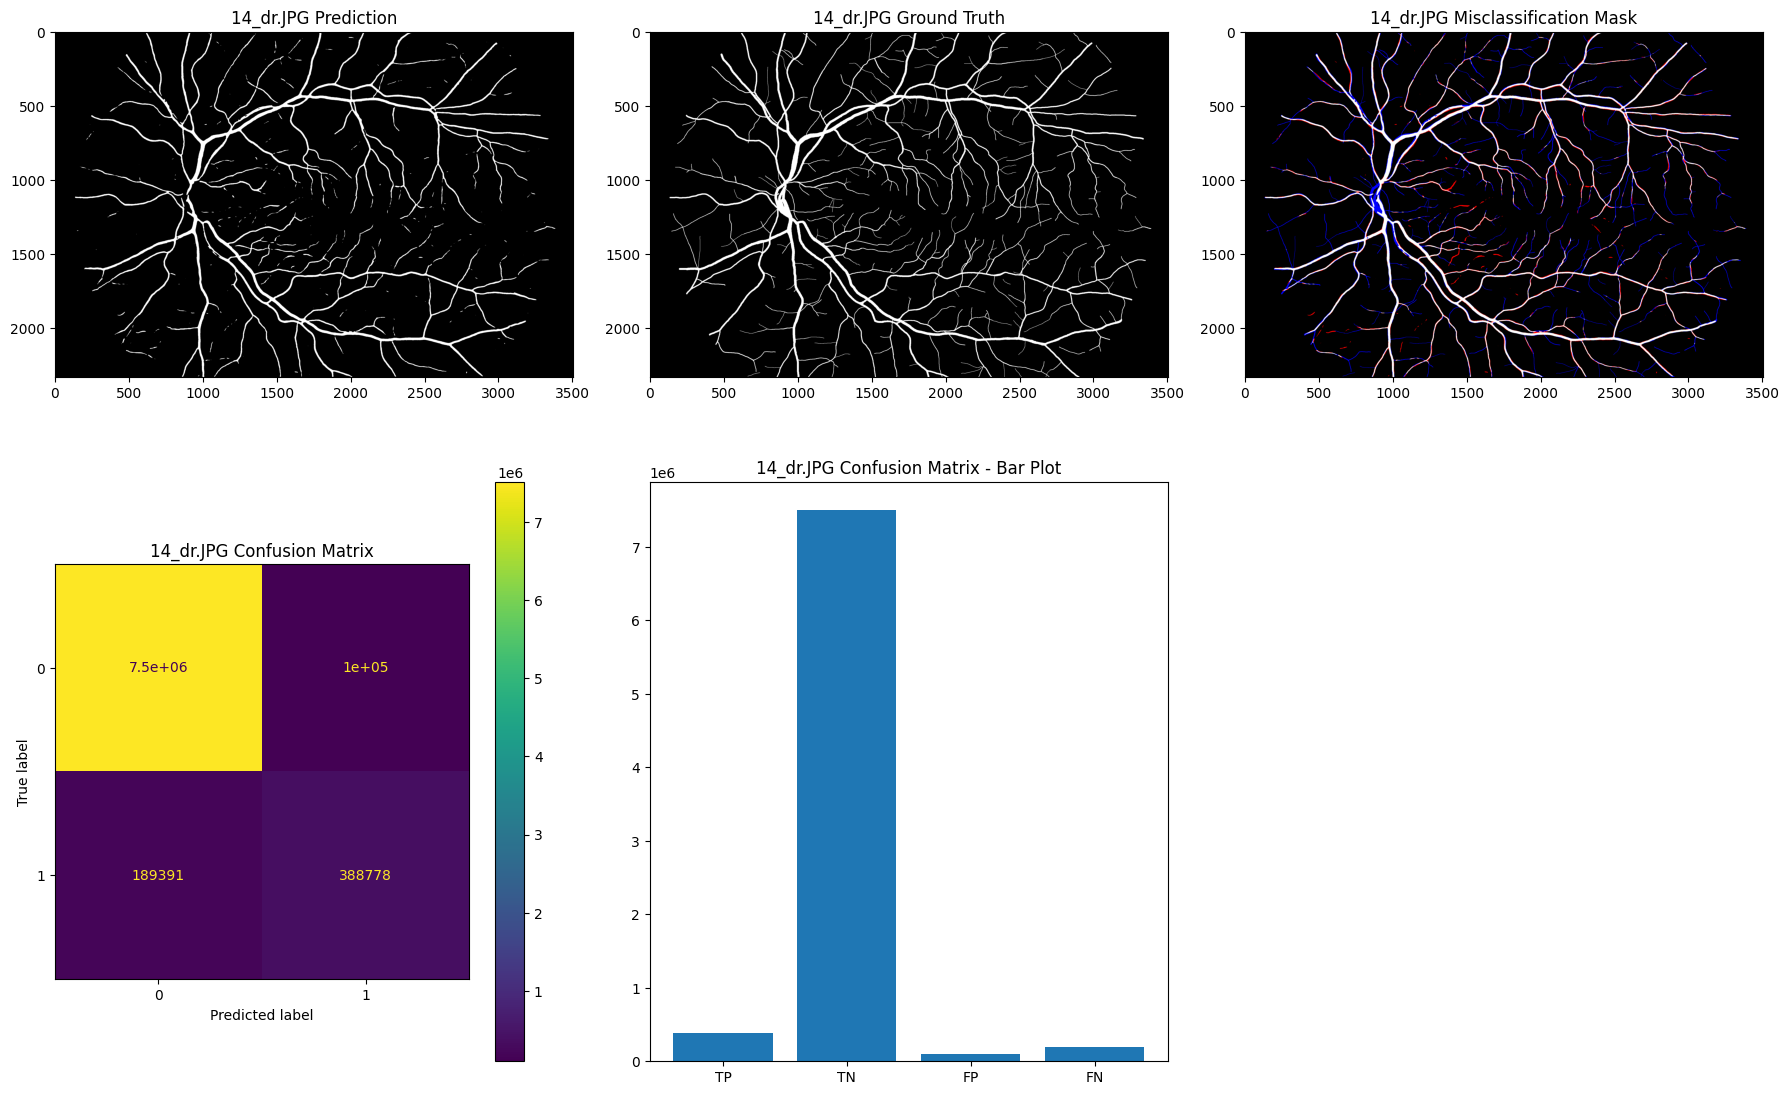

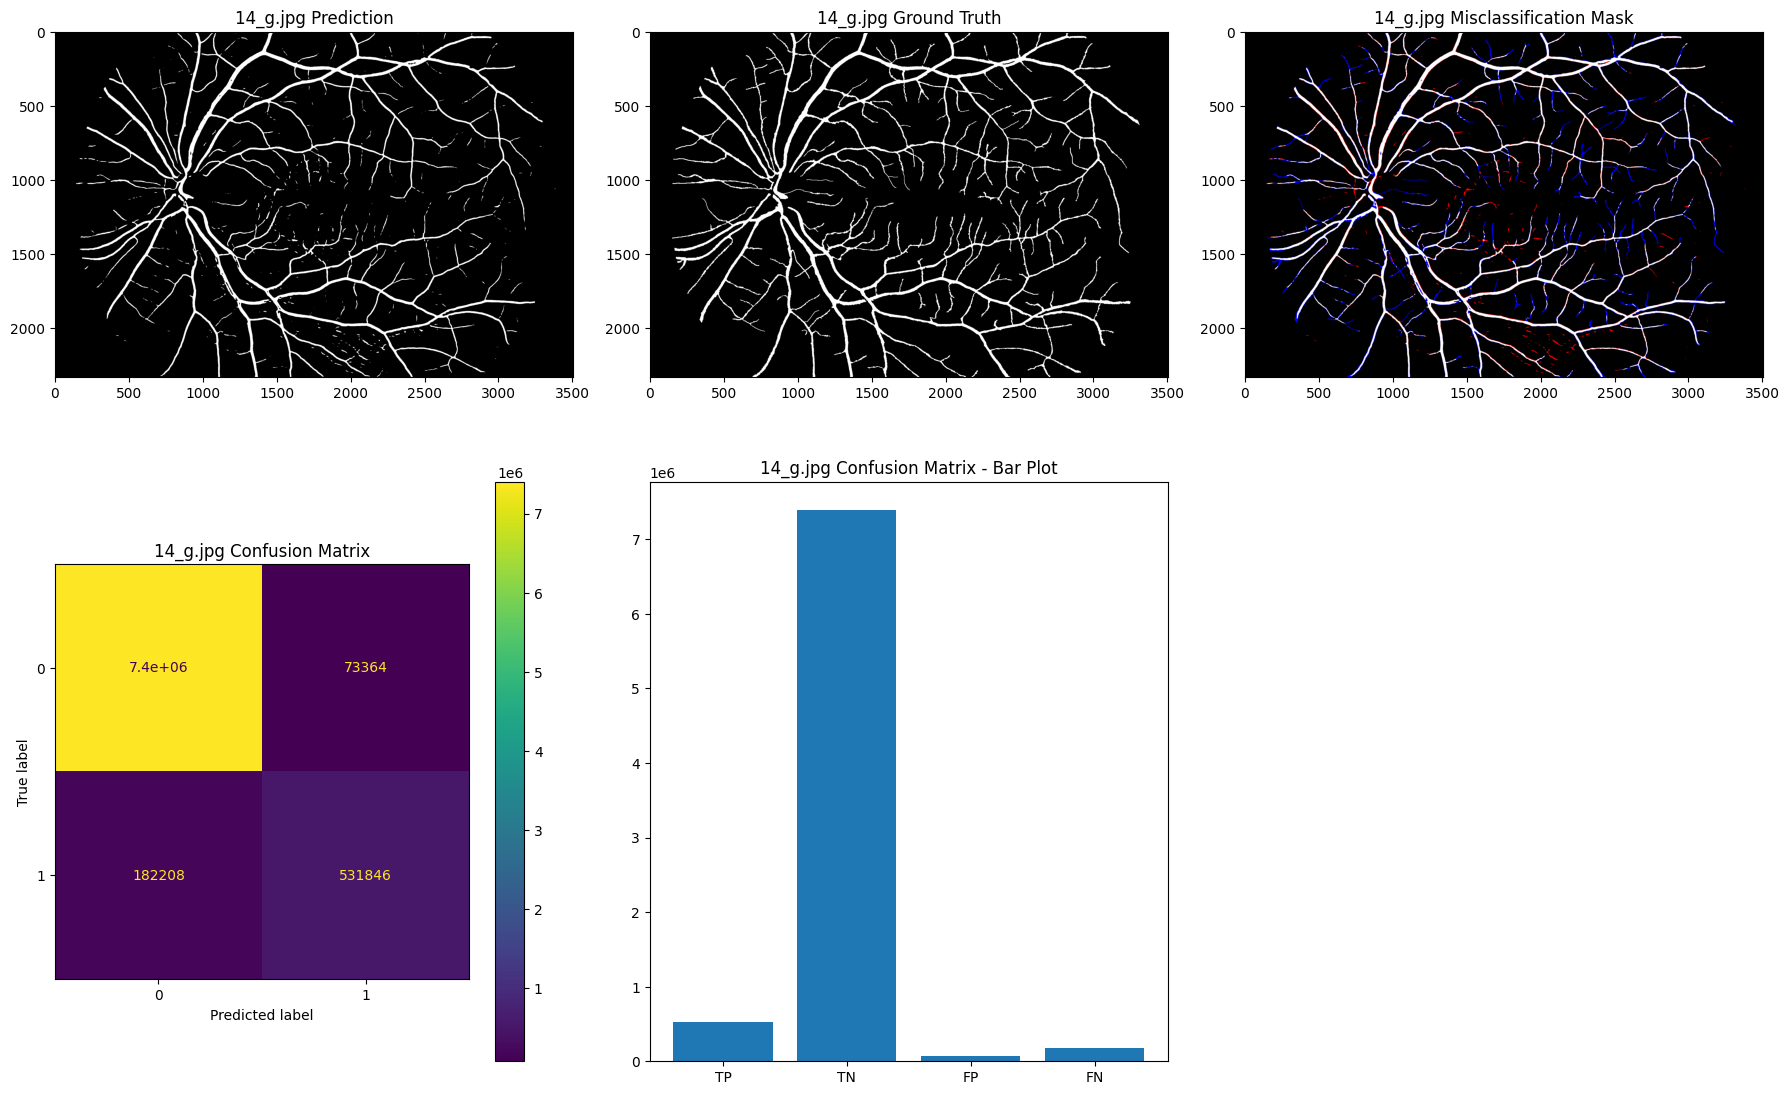

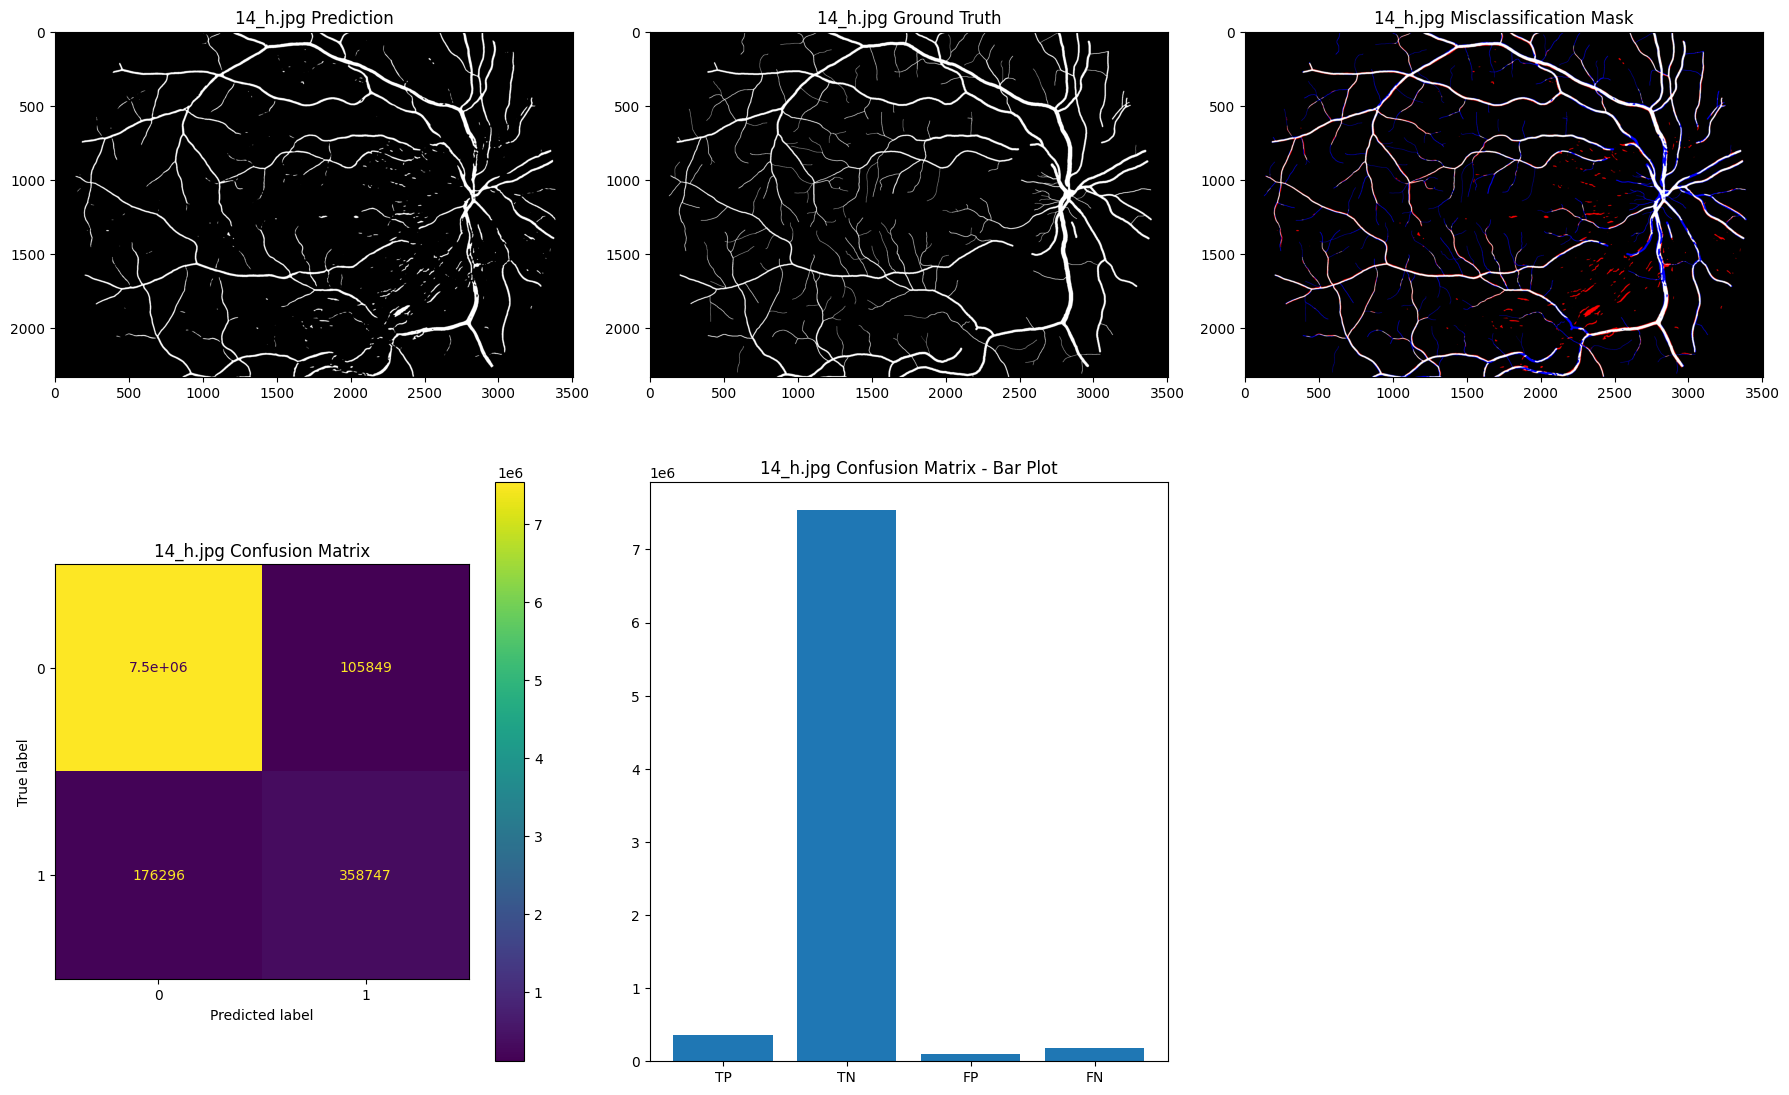

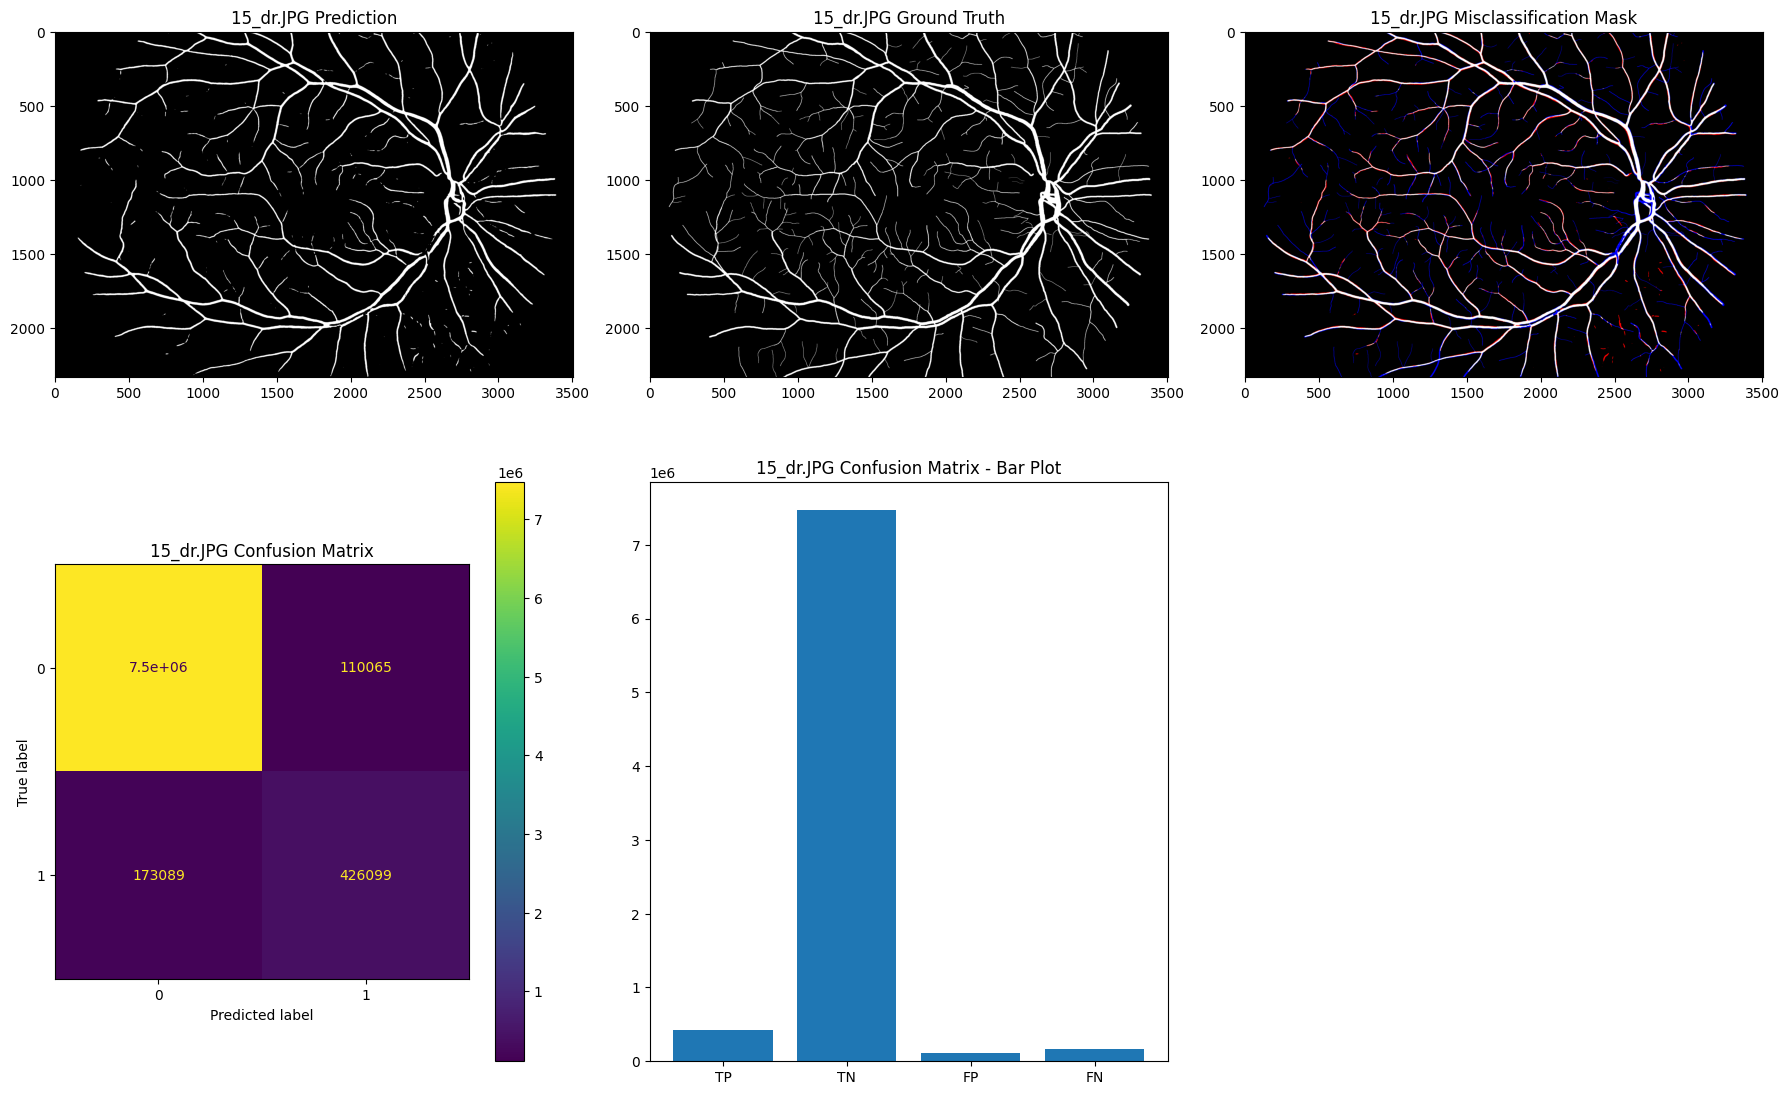

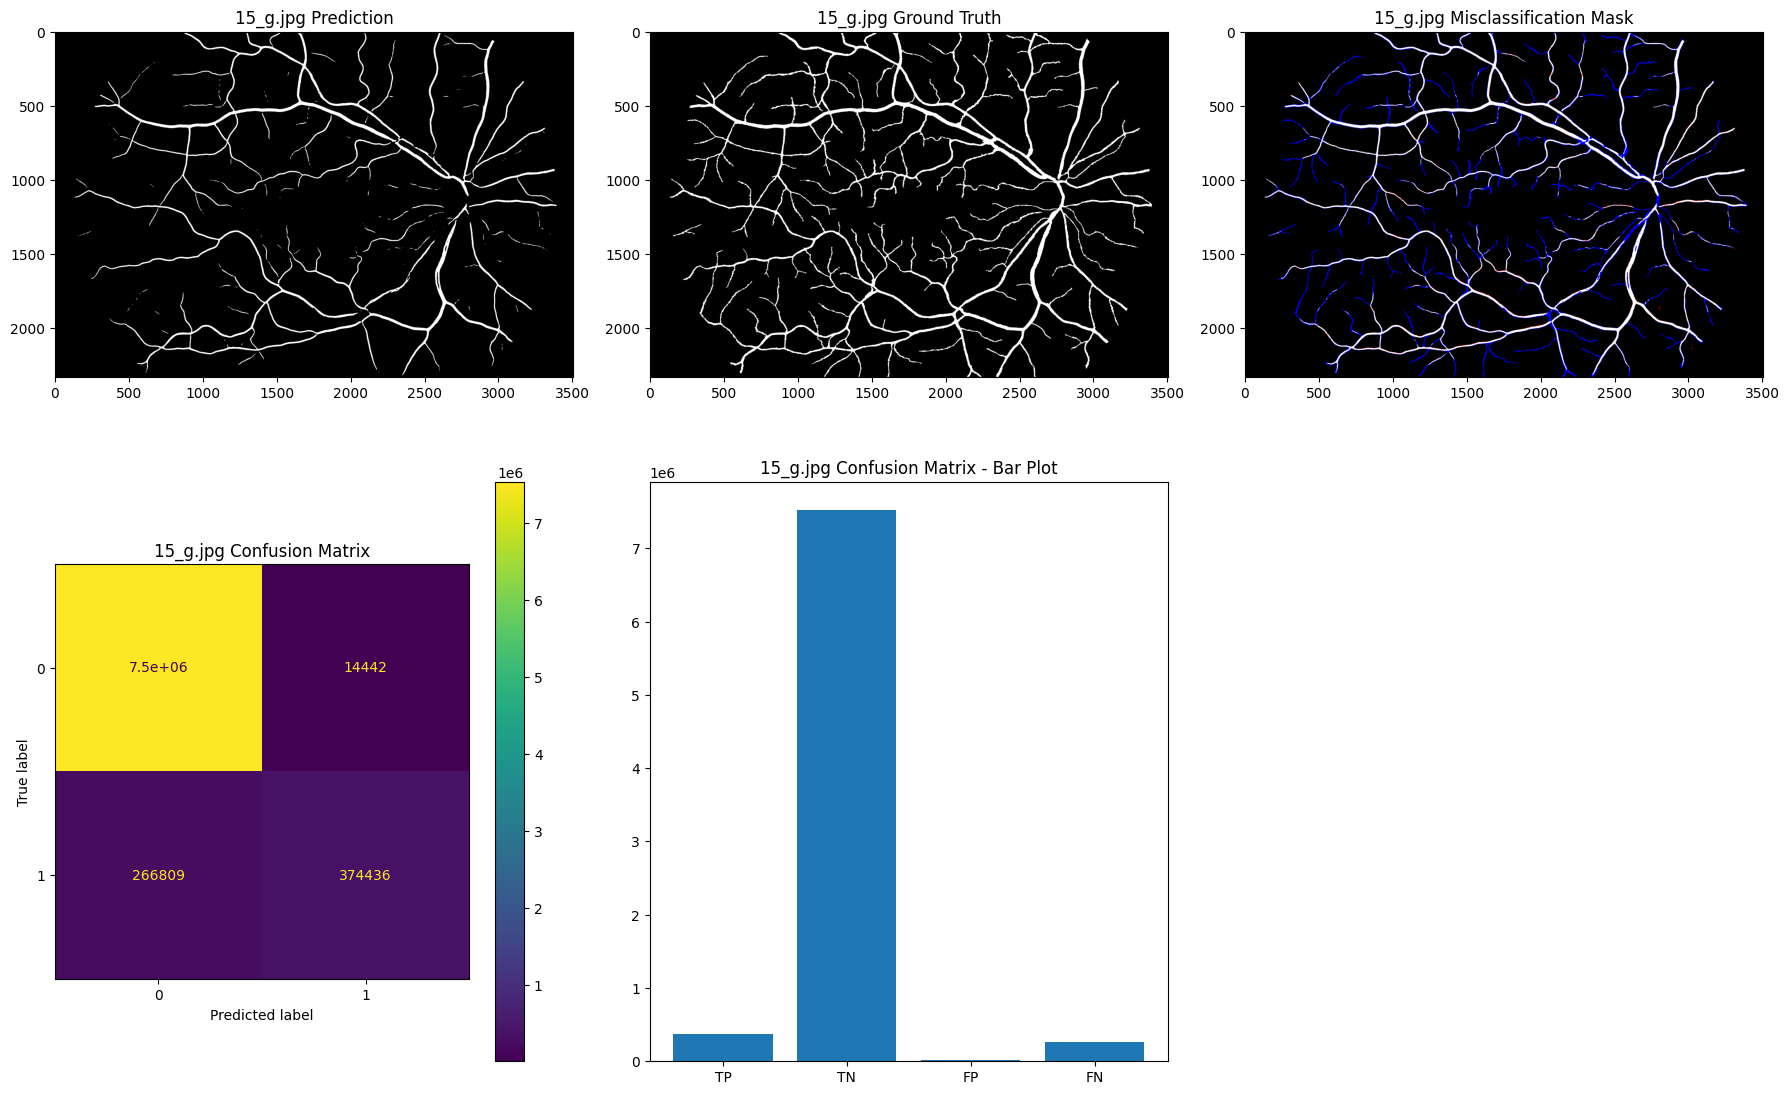

In [29]:
metrics_visualizer = MetricsVisualizer()
for i in range(TEST_SIZE):
  metrics_visualizer.calculate_metrics(expert_masks[i], prediction_masks[i], filenames[TRAIN_IMAGES_NUM + i - 1])
  
metrics_visualizer.visualize()

## Zapis wygernowanych masek do pliku w celu późniejszej analizy i porówniana z innymi modelami

In [33]:
for i in range(TEST_SIZE):
  file_name = f"{filenames[TRAIN_IMAGES_NUM + i -1]}_U-net_model.JPG"
  path = os.path.join(SEGMENTED_IMAGES_FOLDER, file_name)
  cv2.imwrite(path, prediction_masks[i])

## Wczytanie i wyświetlnie zapisanych zdjęć

In [ ]:
# for i in range(TEST_SIZE):
#   file_name = f"{filenames[TRAIN_IMAGES_NUM + 2 -1]}_U-net_model.JPG"
#   path = os.path.join(SEGMENTED_IMAGES_FOLDER, file_name)
#   img = cv2.imread(path)
#   plt.imshow(img)

## Kilka słów o wykorzystanym modelu
Architektura U-Net: U-Net jest popularnym modelem do segmentacji obrazów biomedycznych. Jego architektura składa się z dwóch części: ścieżki skurczającej (contraction path) i ścieżki rozszerzającej (expansive path). Ścieżka skurczająca służy do wykrywania i wyodrębniania ważnych cech z obrazu, a ścieżka rozszerzająca służy do precyzyjnej lokalizacji i segmentacji naczyń krwionośnych. Ta architektura pozwala na skuteczne uwypuklenie i segmentację naczyń.

Warstwy konwolucyjne: Wykorzystanie warstw konwolucyjnych pozwala na automatyczne wyodrębnianie cech z obrazów. Sukcesywne zwiększanie liczby filtrów w warstwach konwolucyjnych (16, 32, 64, 128, 256) w ścieżce skurczającej, a następnie zmniejszanie liczby filtrów w ścieżce rozszerzającej, pozwala na budowanie hierarchicznej reprezentacji obrazu, w której cechy są coraz bardziej szczegółowe.

Warstwy Dropout: Warstwy Dropout są stosowane w celu regularyzacji modelu, co pomaga w zmniejszeniu zjawiska przeuczenia. W modelu zostały zastosowane warstwy Dropout z różnymi współczynnikami (0.1, 0.2, 0.3) w celu losowego wyłączania pewnych neuronów i poprawy ogólnej generalizacji modelu.

Funkcja aktywacji ReLU: Funkcja aktywacji ReLU (Rectified Linear Unit) jest stosowana w większości warstw konwolucyjnych. Jest ona szeroko stosowana w sieciach neuronowych ze względu na swoje korzystne właściwości, takie jak nieskłonność do zanikania gradientu i szybka zbieżność.

Optymalizator Adam i funkcja straty binary_crossentropy: Zastosowanie optymalizatora Adam i funkcji straty binary_crossentropy jest powszechną praktyką przy segmentacji obrazów binarnych. Optymalizator Adam dostosowuje tempo uczenia na podstawie gradientów, co pomaga w skutecznym aktualizowaniu wag modelu. Funkcja straty binary_crossentropy jest używana do mierzenia podobieństwa między wyjściami modelu a oczekiwanymi etykietami binarnymi.